### Estadística descriptiva e inferencial

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Ruta al procesado
data = pd.read_csv('../data/processed/incidencias_asistencia_limpio.csv')

display(data.head())
display(data.info())


,Fecha,Hora,Ciudad,Latitud,Longitud,Tipo_Incidencia,Tipo_Vehiculo,Proveedor,Distancia_km,Tiempo_Respuesta_min,Medio_Retorno,Costo_EUR,Resuelto,SLA_45min_Incumplido,Satisfaccion_1a5,Fecha_Hora
0,2024-12-11,20:42:00,Barcelona,41.38918,2.13438,Combustible,SUV,Proveedor B,17.1,21.3,Taxi,19.02,Sí,No,5.0,2024-12-11 20:42:00
1,2025-02-16,21:14:00,Madrid,40.36878,-3.62800,Neumático,SUV,Proveedor A,43.6,37.7,Grúa,103.20,Sí,No,4.4,2025-02-16 21:14:00
2,2024-10-22,07:19:00,Zaragoza,41.61188,-0.88377,Motor,SUV,Proveedor B,14.3,53.0,Grúa,132.82,Sí,Sí,4.2,2024-10-22 07:19:00
3,2025-04-05,17:33:00,Sevilla,37.39681,-5.95097,Neumático,Furgoneta,Proveedor C,25.5,12.1,Grúa,79.25,Sí,No,5.0,2025-04-05 17:33:00
4,2024-10-10,20:44:00,Sevilla,37.41560,-5.90646,Batería,Furgoneta,Proveedor C,23.8,40.3,Retorno Domicilio,39.36,Sí,No,4.4,2024-10-10 20:44:00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Fecha                 900 non-null    object 
 1   Hora                  900 non-null    object 
 2   Ciudad                900 non-null    object 
 3   Latitud               900 non-null    float64
 4   Longitud              900 non-null    float64
 5   Tipo_Incidencia       900 non-null    object 
 6   Tipo_Vehiculo         900 non-null    object 
 7   Proveedor             900 non-null    object 
 8   Distancia_km          900 non-null    float64
 9   Tiempo_Respuesta_min  900 non-null    float64
 10  Medio_Retorno         900 non-null    object 
 11  Costo_EUR             900 non-null    float64
 12  Resuelto              900 non-null    object 
 13  SLA_45min_Incumplido  900 non-null    object 
 14  Satisfaccion_1a5      900 non-null    float64
 15  Fecha_Hora            9

None

In [47]:
# Diccionario de variables

dicc = {
    "Tiempo_Respuesta_min": "Tiempo de respuesta en minutos",
    "Costo_EUR": "Coste del servicio (€)",
    "Satisfaccion_1a5": "Satisfacción (1–5)",
    "Tipo_Incidencia": "Tipo de incidencia",
    "Ciudad": "Ciudad",
    "Distancia_km": "Distancia del servicio (km)",
    "Resuelto": "Incidencia resuelta (Sí/No)",
    "SLA_Incumplido": "Incumplimiento SLA 45 min (0/1)",
    "Mes": "Mes",
    "Anio": "Año"
}
pd.Series(dicc)


Tiempo_Respuesta_min     Tiempo de respuesta en minutos
Costo_EUR                        Coste del servicio (€)
Satisfaccion_1a5                     Satisfacción (1–5)
Tipo_Incidencia                      Tipo de incidencia
Ciudad                                           Ciudad
Distancia_km                Distancia del servicio (km)
Resuelto                    Incidencia resuelta (Sí/No)
SLA_Incumplido          Incumplimiento SLA 45 min (0/1)
Mes                                                 Mes
Anio                                                Año
dtype: object

#### Estadistica descriptiva

In [48]:
# Métricas globales

num_cols = ["Tiempo_Respuesta_min", "Costo_EUR", "Satisfaccion_1a5", "Distancia_km"]
desc = data[num_cols].describe(percentiles=[.25,.5,.75,.9,.95]).T
desc["IQR"] = desc["75%"] - desc["25%"]
desc

,count,mean,std,min,25%,50%,75%,90%,95%,max,IQR
Tiempo_Respuesta_min,900.0,38.481444,15.058023,10.00,27.800,36.900,47.500,57.900,65.705,99.20,19.70
Costo_EUR,900.0,82.320978,64.133442,-8.33,27.370,68.815,130.160,177.118,202.325,280.59,102.79
Satisfaccion_1a5,900.0,4.227222,0.870824,1.00,3.700,4.500,5.000,5.000,5.000,5.00,1.30
Distancia_km,900.0,18.457778,9.600135,0.00,11.775,18.400,25.125,31.200,34.305,43.60,13.35


In [49]:
# Por grupo
def resumen_por_grupo(data, group, cols=num_cols):
    out = (data.groupby(group)[cols]
             .agg(["count", "mean", "median", "std", "min", "max"])
             .round(2))
    return out

resumen_por_grupo(data, "Tipo_Incidencia")
resumen_por_grupo(data, "Ciudad")


Tiempo_Respuesta_min                                  Costo_EUR  \
                         count   mean median    std   min   max     count   
Ciudad                                                                      
Barcelona                  119  42.91   42.2  17.14  10.0  99.2       119   
Bilbao                     117  37.25   35.1  14.79  10.0  79.1       117   
Madrid                      99  41.41   38.5  16.67  10.0  84.0        99   
Málaga                      94  35.97   36.0  13.30  10.0  78.4        94   
Oviedo                     123  39.16   36.2  14.16  12.8  78.3       123   
Sevilla                    126  39.19   37.4  15.22  10.0  90.0       126   
Valencia                    97  36.95   36.2  14.08  10.0  87.7        97   
Zaragoza                   125  34.80   35.2  13.22  10.0  67.5       125   

                                             Satisfaccion_1a5               \
            mean median    std   min     max            count  mean median   
Ciudad                                                                       
Barcelona  91.37  85.05  66.93  4.83  271.01              119  4.04   4.30   
Bilbao     82.33  49.01  67.11 -6.02  273.33              117  4.18   4.50   
Madrid     99.02  93.06  68.54  4.10  280.59               99  4.00   4.20   
Málaga     78.72  73.35  62.96  4.92  266.04               94  4.36   4.80   
Oviedo     74.02  58.36  61.58  1.52  229.24              123  4.29   4.60   
Sevilla    78.15  62.50  60.72  7.94  247.75              126  4.28   4.55   
Valencia   81.54  75.85  61.13  0.94  222.18               97  4.31   4.60   
Zaragoza   76.16  48.31  62.30 -8.33  251.38              125  4.35   4.60   

                          Distancia_km                                  
            std  min  max        count   mean median    std  min   max  
Ciudad                                                                  
Barcelona  0.97  1.0  5.0          119  18.02   17.2  10.09  0.0  41.7  
Bilbao     0.90  1.8  5.0          117  17.45   17.9   9.61  0.0  43.3  
Madrid     0.97  1.5  5.0           99  19.26   20.0   9.76  0.0  43.6  
Málaga     0.83  1.2  5.0           94  19.87   20.5   9.79  0.0  37.9  
Oviedo     0.87  1.4  5.0          123  19.09   19.6   9.87  0.0  43.4  
Sevilla    0.81  2.0  5.0          126  17.66   17.9   9.19  0.0  40.4  
Valencia   0.82  1.3  5.0           97  18.39   17.3   9.52  0.0  40.9  
Zaragoza   0.74  2.1  5.0          125  18.36   18.9   9.08  0.0  41.0

In [50]:
# Tablas de contingencia (categóricas)
pd.crosstab(data["Tipo_Incidencia"], data["SLA_45min_Incumplido"], margins=True, normalize="index").round(3)


SLA_45min_Incumplido,No,Sí
Tipo_Incidencia,,
Accidente,0.264,0.736
Batería,0.873,0.127
Caja de cambios,0.459,0.541
Combustible,0.914,0.086
Motor,0.383,0.617
Neumático,0.811,0.189
Sistema eléctrico,0.663,0.337
All,0.700,0.300


In [51]:
# Normalidad y outliers (checks rápidos)

# Shapiro-Wilk en una muestra
sample = data["Tiempo_Respuesta_min"].dropna().sample(min(5000, data.shape[0]), random_state=42)
stats.shapiro(sample)

# Z-scores para outliers (criterio |z| > 3)
z = stats.zscore(data[num_cols].dropna())
outliers = (np.abs(z) > 3).any(axis=1)
data_outliers = data.loc[data[num_cols].dropna().index[outliers]]
data_outliers.shape, data_outliers.head()


((12, 16),
           Fecha      Hora     Ciudad   Latitud  Longitud Tipo_Incidencia  \
 32   2025-01-24  23:46:00     Málaga  36.70868  -4.52980       Accidente   
 160  2025-06-06  08:12:00  Barcelona  41.26544   2.18787       Accidente   
 407  2025-04-09  07:08:00    Sevilla  37.30861  -6.15264       Accidente   
 430  2025-04-24  10:05:00  Barcelona  41.44346   2.22724       Accidente   
 455  2024-09-09  22:38:00   Valencia  39.41022  -0.42922       Accidente   
 
     Tipo_Vehiculo    Proveedor  Distancia_km  Tiempo_Respuesta_min  \
 32            SUV  Proveedor B          30.0                  78.4   
 160       Turismo  Proveedor B          29.0                  99.2   
 407       Turismo  Proveedor C          32.0                  90.0   
 430       Turismo  Proveedor C           2.4                  89.5   
 455       Turismo  Proveedor A          23.0                  60.6   
 
     Medio_Retorno  Costo_EUR Resuelto SLA_45min_Incumplido  Satisfaccion_1a5  \
 32           Gr

#### Contrastes de hipótesis

In [52]:
#¿Costo medio difiere por tipo de incidencia?
# ANOVA de una vía
groups = [g.dropna() for _, g in data.groupby("Tipo_Incidencia")["Costo_EUR"]]
fstat, pval = stats.f_oneway(*groups)
print(f"ANOVA: F = {fstat:.3f} | p = {pval:.3g}")

# Si no cumple supuestos:
kw = stats.kruskal(*groups)
print(f"Kruskal-Wallis: H = {kw.statistic:.3f} | p = {kw.pvalue:.3g}")

resumen = (data.groupby("Tipo_Incidencia")["Costo_EUR"]
           .agg(count="count", mean="mean", median="median", std="std")
           .sort_values("mean", ascending=False))
print(resumen)

from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=data["Costo_EUR"],
                          groups=data["Tipo_Incidencia"], alpha=0.05)
print(tukey.summary())


ANOVA: F = 359.371 | p = 3.68e-234
Kruskal-Wallis: H = 549.095 | p = 2.21e-115
                   count        mean   median        std
Tipo_Incidencia                                         
Accidente             53  200.699057  199.280  43.569083
Caja de cambios       74  161.769324  162.420  34.596063
Motor                128  151.438516  148.065  31.594319
Sistema eléctrico     95   79.383474   54.290  50.369702
Batería              212   49.492453   34.405  33.923013
Neumático            233   43.884721   31.110  31.013004
Combustible          105   36.550476   27.000  25.117265
             Multiple Comparison of Means - Tukey HSD, FWER=0.05             
     group1           group2       meandiff p-adj    lower     upper   reject
-----------------------------------------------------------------------------
      Accidente           Batería -151.2066    0.0 -167.0102 -135.4031   True
      Accidente   Caja de cambios  -38.9297    0.0  -57.4474  -20.4121   True
      Accidente   

In [53]:
# Asociación entre categóricas
tab = pd.crosstab(data["Tipo_Incidencia"], data["SLA_45min_Incumplido"])
chi2, p, dof, exp = stats.chi2_contingency(tab)
print(f"Chi2 = {chi2:.2f} | p = {p:.3g} | dof = {dof}")


Chi2 = 197.03 | p = 8.15e-40 | dof = 6


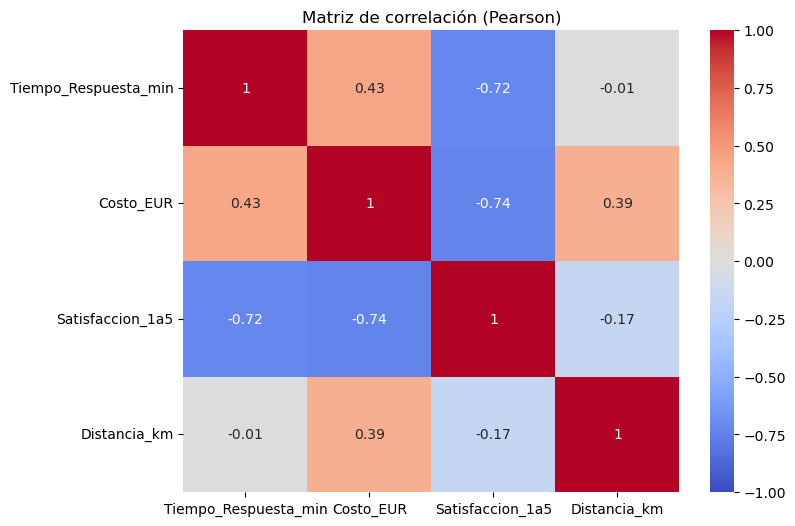

,Tiempo_Respuesta_min,Costo_EUR,Satisfaccion_1a5,Distancia_km
Tiempo_Respuesta_min,1.00,0.43,-0.72,-0.01
Costo_EUR,0.43,1.00,-0.74,0.39
Satisfaccion_1a5,-0.72,-0.74,1.00,-0.17
Distancia_km,-0.01,0.39,-0.17,1.00


In [54]:
# Correlación entre variables numéricas
corr = data[num_cols].corr(method="pearson").round(2)
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Matriz de correlación (Pearson)")
plt.show()

corr


#### Modelos sencillos

In [55]:
# Regresión lineal: Costo en función de Tiempo de respuesta y Distancia

modelo = smf.ols("Costo_EUR ~ Tiempo_Respuesta_min + Distancia_km + C(Tipo_Incidencia)", data=data).fit()
print(modelo.summary())


                            OLS Regression Results                            
Dep. Variable:              Costo_EUR   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     908.1
Date:                Thu, 11 Sep 2025   Prob (F-statistic):               0.00
Time:                        19:20:59   Log-Likelihood:                -4025.0
No. Observations:                 900   AIC:                             8068.
Df Residuals:                     891   BIC:                             8111.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [63]:
# Preparación de variables para el modelo (SLA 0/1 y predictores)

# Target 0/1 desde "Sí/No"
def _norm_txt(s):
    s = unicodedata.normalize('NFKD', str(s))
    s = ''.join(ch for ch in s if not unicodedata.combining(ch))
    return s.strip().lower()

data["SLA_Incumplido"] = (
    data["SLA_45min_Incumplido"].map(_norm_txt).map({"si":1, "no":0}).astype("Int64")
)

# Predictores limpios 

data["Distancia_km"] = pd.to_numeric(data["Distancia_km"], errors="coerce")
data["Ciudad"] = data["Ciudad"].astype(str).str.strip()

# ==== 3) Dataset del modelo (SIN Tiempo_Respuesta_min) ====
dm = data[["SLA_Incumplido", "Distancia_km", "Ciudad"]].dropna()

# Ciudad de referencia
ref_city = "Madrid" if "Madrid" in dm["Ciudad"].unique() else dm["Ciudad"].mode().iat[0]


# Regresión logística (sin fuga): SLA_Incumplido ~ Distancia_km + Ciudad
logit = smf.logit(
    f"SLA_Incumplido ~ Distancia_km + C(Ciudad, Treatment(reference='{ref_city}'))",
    data=dm
).fit()
print(logit.summary())

# Interpretación: Odds Ratios (OR) e Intervalos de Confianza 95%
params = logit.params
conf   = logit.conf_int()
or_tab = pd.DataFrame({
    "OR": np.exp(params),
    "IC95%_Inf": np.exp(conf[0]),
    "IC95%_Sup": np.exp(conf[1]),
    "p": logit.pvalues
}).round(3)

or_tab.sort_values("OR", ascending=False)


Optimization terminated successfully.
         Current function value: 0.597692
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:         SLA_Incumplido   No. Observations:                  900
Model:                          Logit   Df Residuals:                      891
Method:                           MLE   Df Model:                            8
Date:                Thu, 11 Sep 2025   Pseudo R-squ.:                 0.02156
Time:                        19:52:17   Log-Likelihood:                -537.92
converged:                       True   LL-Null:                       -549.78
Covariance Type:            nonrobust   LLR p-value:                  0.002563
                                                            coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
Intercept             

,OR,IC95%_Inf,IC95%_Sup,p
"C(Ciudad, Treatment(reference='Madrid'))[T.Barcelona]",1.022,0.594,1.760,0.938
Distancia_km,0.992,0.977,1.007,0.280
Intercept,0.795,0.485,1.304,0.364
"C(Ciudad, Treatment(reference='Madrid'))[T.Bilbao]",0.672,0.383,1.176,0.164
"C(Ciudad, Treatment(reference='Madrid'))[T.Sevilla]",0.652,0.375,1.133,0.129
"C(Ciudad, Treatment(reference='Madrid'))[T.Oviedo]",0.609,0.348,1.065,0.082
"C(Ciudad, Treatment(reference='Madrid'))[T.Valencia]",0.429,0.230,0.800,0.008
"C(Ciudad, Treatment(reference='Madrid'))[T.Málaga]",0.426,0.227,0.800,0.008
"C(Ciudad, Treatment(reference='Madrid'))[T.Zaragoza]",0.384,0.213,0.693,0.001


In [ ]:
# Probabilidad predicha de incumplir (para usar en Power BI)
data.loc[dm.index, "Prob_Incumplir"] = logit.predict(dm)